In [275]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, ifft
from scipy.fft import fft2, ifft2

1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



The predicted maximum wind speed for a 50-year return period is 32.98 m/s.


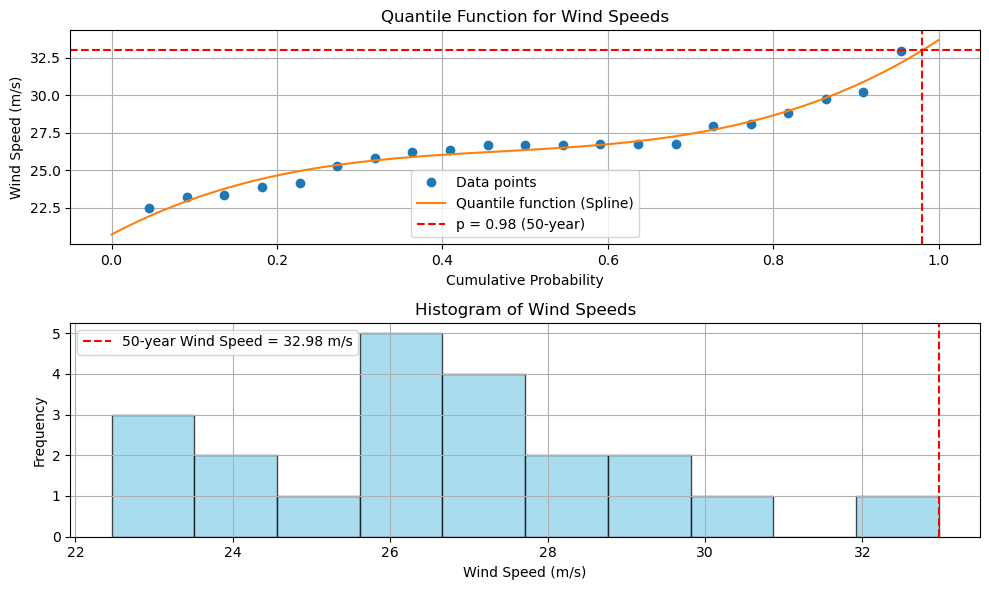

In [276]:
# load the dataset
max_speeds = np.load('max-speeds.npy') # load the data -> annual max speed wind registered
years_nb = max_speeds.shape[0] # total number of years for data collection

# compute the cumulative probability and sort the maximum speeds from the data 
max_speeds = np.sort(max_speeds)
cprob = [(i/(years_nb + 1)) for i in range(1, years_nb + 1)] 

# Use the UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities
quantile = sp.interpolate.UnivariateSpline(cprob, max_speeds) #could also use additional arguments k = 3, s = 0 would've obtained a different result

# Guess the wind speed occuring every 50 years
fifty_prob = 1. - 0.02
fifty_wind = quantile(fifty_prob)

print(f"The predicted maximum wind speed for a 50-year return period is {fifty_wind:.2f} m/s.")

# If you want to do some plotting... 
plt.figure(figsize=(10, 6))

# Cumulative probabilities
plt.subplot(2, 1, 1)
plt.plot(cprob, max_speeds, 'o', label='Data points')
cprob_range = np.linspace(0, 1, 100)
plt.plot(cprob_range, quantile(cprob_range), '-', label='Quantile function (Spline)')
plt.axvline(x=fifty_prob, color='r', linestyle='--', label="p = 0.98 (50-year)")
plt.axhline(y=fifty_wind, color='r', linestyle='--')
plt.xlabel("Cumulative Probability")
plt.ylabel("Wind Speed (m/s)")
plt.title("Quantile Function for Wind Speeds")
plt.legend()
plt.grid()

# Plot the histogram of wind speeds
plt.subplot(2, 1, 2)
plt.hist(max_speeds, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=fifty_wind, color='r', linestyle='--', label=f"50-year Wind Speed = {fifty_wind:.2f} m/s")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Frequency")
plt.title("Histogram of Wind Speeds")
plt.legend()
plt.grid()

# Display all plots
plt.tight_layout()
plt.show()

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celsius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

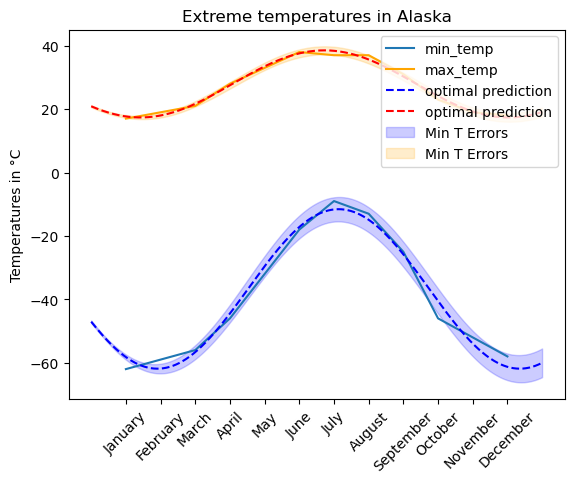

Offset for minimum temperatures: 4.520751737273629 ± 0.37712021433923726
Offset for maximum temperatures: 4.070631223537129 ± 0.3462789558773781


In [277]:
# Load the data
max_temp = [17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18]
min_temp = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]
month_idx = [idx for idx in range(1,13)]
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plot the temperature extremes
plt.plot(month_idx, min_temp, label = 'min_temp')
plt.plot(month_idx, max_temp, color = 'orange', label = 'max_temp')
plt.xticks(ticks = month_idx, labels = month_names, rotation = 45)
plt.ylabel('Temperatures in °C')
plt.title('Extreme temperatures in Alaska')

# Define a function that can describe min and max temperatures
t = np.linspace(0,13,1000)
def pred(t, A, freq, v_shift, t0): 
    return A*np.sin(2*np.pi*freq*(t - t0)) + v_shift

min_params = [(np.max(min_temp)-np.min(min_temp))/2, 1/12, (np.max(min_temp)+np.min(min_temp))/2, np.pi]
max_params = [(np.max(max_temp)-np.min(max_temp))/2, 1/12, (np.max(max_temp)+np.min(max_temp))/2, np.pi]

#plt.plot(t, pred(t, *min_params), color = 'green', ls = 'dotted')
#plt.plot(t, pred(t, *max_params), color = 'green', ls = 'dotted', label = 'guessed prediction')

# Fit this function to the data with scipy.optimize.curve_fit()
min_opt, min_opt_cov = sp.optimize.curve_fit(pred, month_idx, min_temp, min_params)
max_opt, max_opt_cov = sp.optimize.curve_fit(pred, month_idx, max_temp, max_params)

# Plot the result
plt.plot(t, pred(t, *min_opt), color = 'blue', ls = 'dashed', label = 'optimal prediction')
plt.plot(t, pred(t, *max_opt), color = 'red', ls = 'dashed', label = 'optimal prediction')

# Propagate the errors on the parameters to get the error on the fit
def fit_error(t, popt, pcov):
    # Gradient of the fit function with respect to each parameter
    partials = np.array([
        np.sin(2 * np.pi * (t - popt[1]) / popt[2]),                          # Derivative w.r.t A
        -popt[0] * np.cos(2 * np.pi * (t - popt[1]) / popt[2]) * (2 * np.pi / popt[2]),  # Derivative w.r.t t0
        popt[0] * np.cos(2 * np.pi * (t - popt[1]) / popt[2]) * (2 * np.pi * (t - popt[1]) / popt[2]**2),  # Derivative w.r.t P
        np.ones_like(t)                                                       # Derivative w.r.t C
    ])
    
    var = np.diagonal(pcov)
    #print("cov matrix for params\n", pcov) 

    fit_var= np.sum(partials.T**2 * var, axis=1)  # Sum of squared gradients × parameter variances
    return np.sqrt(fit_var)  # Standard deviation for the fit

# Error bounds
fit_min_error = fit_error(t, min_opt, min_opt_cov)
fit_max_error = fit_error(t, max_opt, max_opt_cov)

#print(np.shape(fit_min_error))

# Plot the fits
plt.fill_between(t, pred(t, *min_opt) - 3*fit_min_error, pred(t, *min_opt) + 3*fit_min_error, color='blue', alpha=0.2, label='Min T Errors')
plt.fill_between(t, pred(t, *max_opt) - 3*fit_max_error, pred(t, *max_opt) + 3*fit_max_error, color='orange', alpha=0.2, label='Min T Errors')

# Final plot adjustments
plt.legend(loc='upper right')
plt.show()

# Check time offset and its error
t0_min = min_opt[3]
t0_min_error = 3 * np.sqrt(np.diagonal(min_opt_cov)[3])

t0_max = max_opt[3]
t0_max_error = 3 * np.sqrt(np.diagonal(max_opt_cov)[3])

print("Offset for minimum temperatures:", t0_min, '±',t0_min_error)
print("Offset for maximum temperatures:", t0_max, '±',t0_max_error)


**COMMENT:**
> Is the fit reasonable? If not, why?

The fit looks reasonable, the data are in between three standard deviations from the prediction. 

> Is the time offset for min and max temperatures the same within the fit accuracy?

Within the fit accuracy the time offset is the same within three standard deviations. 

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


Found local minimum at: x=0.0898418376044679, y=-0.7126562815312288, value=-1.0316284534896578
Found local minimum at: x=-0.08984172720156086, y=0.7126562299342476, value=-1.031628453489363
Found local minimum at: x=1.7036067127605794, y=-0.796083575866438, value=-0.21546382438371847
Found local minimum at: x=-1.7036068050953819, y=0.7960837098644359, value=-0.2154638243834307
Found local minimum at: x=-1.6071044477637073, y=-0.5686518662558079, value=2.104250310312219
Found local minimum at: x=1.6071047817694764, y=0.5686514457275055, value=2.1042503103112615
Number of unique local minima found: 6
Global minima: x=0.0898418376044679, y=-0.7126562815312288, value=-1.0316284534896578
Found local minimum at: x=-0.08985145273780815, y=0.7126653796314092, value=-1.031628452567338


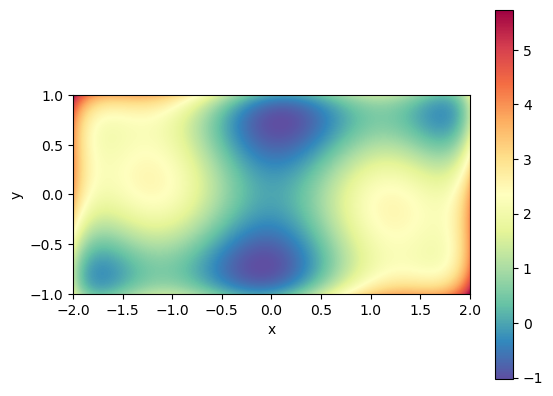

In [278]:
# Define the six - hump camelback function
def func(v): #optimize.minimize requires that func has only one argument, hence I define it like this
    x, y = v
    coeff1 = 4 - 2.1*(x**2) + (x**4)/3
    coeff2 = 4*(y**2) - 4
    return coeff1*(x**2) + x*y + coeff2*(y**2)

# Plot it on a grid using imshow
x = np.linspace(-2,2,1000) 
y = np.linspace(-1,1,1000)

grid = np.meshgrid(x,y) # shape (2,1000,1000): returns xx which is a matrix with copies of x as rows and yy copies of y as columns
                        #so xx,yy form a grid with all possible combinations --> zz = func((xx,yy)) 
f = func(grid) 
plt.imshow(f, extent=[-2, 2, -1, 1], cmap='Spectral_r') # Spectral_r is the reversed of spectral colormap
plt.colorbar() #Shows the "legend" on the side
plt.xlabel('x')
plt.ylabel('y')

# Find the minima
x_vals = np.linspace(-2, 2, 40)  # 20 points for x
y_vals = np.linspace(-1, 1, 40)  # 10 points for y
initial_guesses = [(x, y) for x in x_vals for y in y_vals]  # Create combinations of (x, y) from the grid

local_minima = []
tolerance_distance = 1e-5  # A small tolerance for considering close minima as the same one

# Function to check if a point is very close to an already found minimum (based on (x, y) distance)
def is_close(minima, new_minimum):
    for minimum in minima:
        # Calculate the Euclidean distance between the (x, y) values
        distance = np.sqrt((minimum[0] - new_minimum[0])**2 + (minimum[1] - new_minimum[1])**2)
        if distance < tolerance_distance:  # If the distance between coordinates is too small, consider them close
            return True
    return False

# Run optimization from each initial guess
for guess in initial_guesses:
    result = sp.optimize.minimize(func, guess, method='BFGS') 
    if result.success:
        new_minimum = (result.x[0], result.x[1], result.fun)
        # Only add the new minimum if it's not too close to any existing minima
        if not is_close(local_minima, new_minimum):
            local_minima.append(new_minimum)
            print(f"Found local minimum at: x={result.x[0]}, y={result.x[1]}, value={result.fun}")
    else:
        print(f"Minimization failed for starting point {guess}")

# After exploration, count the number of found local minima
num_local_minima = len(local_minima)
print(f"Number of unique local minima found: {num_local_minima}")

# Identifying the global minimum (minimal function value)
global_minimum = min(local_minima, key=lambda x: x[2])
print(f"Global minima: x={global_minimum[0]}, y={global_minimum[1]}, value={global_minimum[2]}")

#Let's see what happens for (0,0) as initial guess
result_00 = sp.optimize.minimize(func,(0,0), method = 'Nelder-Mead')
if result.success: 
    print(f"Found local minimum at: x={result_00.x[0]}, y={result_00.x[1]}, value={result_00.fun}")
else: 
    print("Minimization failed for starting point (0,0)")

**COMMENT:**
> How many global minima are there, and what is the function value at those points?

There are as expected 6 local minima, two of which are global minima (because of symmetry). 

> What happens for an initial guess of (x,y) = (0,0) ?

If I start exactly at (0,0), it will be considered as a minimum, even tho it's a saddle point, when using the default BFGS method. The result indeed depends on the specific algorithm and how the algorithm explores the function landscape. Even though mathematically, (0, 0) is a saddle point based on the Hessian (which suggests zero curvature along one direction and negative curvature along another), the optimizer could behave differently depending on various factors. If you use for example 'Nelder-Mead' you don't have that problem any longer: the algorithm converges to one of the actual local minima. 

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

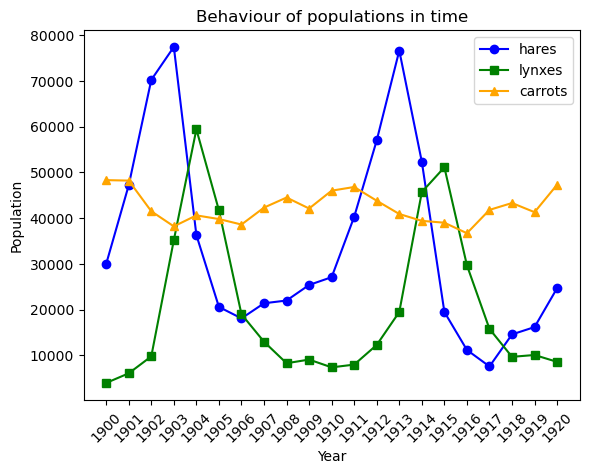

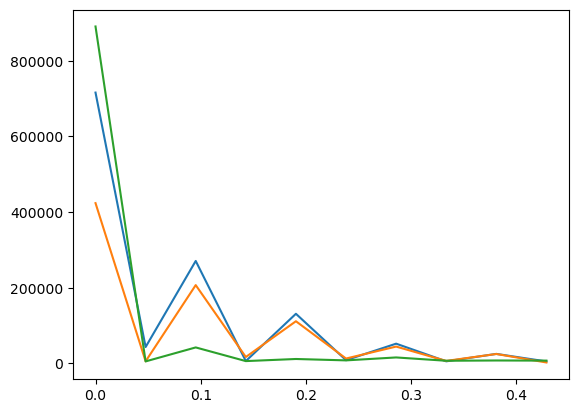

In [279]:
# Load the data
#! cat populations.txt
data = np.loadtxt('populations.txt')

year = data[:,0]
hares = data[:,1]
lynxes = data[:,2]
carrots = data[:,3]

# Plot the data

plt.plot(year, hares, color = 'Blue', marker = 'o', label = 'hares')
plt.plot(year, lynxes, color = 'Green', marker = 's', label = 'lynxes')
plt.plot(year, carrots, color = 'Orange', marker = '^', label = 'carrots')
plt.xticks(year, rotation = 45)
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Behaviour of populations in time')
plt.legend(loc = 'best')
plt.show()

# Perform the periodicity analysis
fft_populations = [] # Fourier transform of the population for each specie
fft_frequencies = [] # Corresponding frequencies
populations = [hares, lynxes, carrots]
species = ['hares', 'lynxes', 'carrots']
for idx, specie in enumerate(species): 
    signal = populations[idx]
    fft_pop = np.abs(fft(signal))
    fft_freq = fftfreq(len(signal),1)
    fft_populations.append(fft_pop)
    fft_frequencies.append(fft_freq)
    plt.plot(fft_freq[:int(len(fft_freq)/2)], fft_pop[:int(len(fft_pop)/2)], label = specie)


**COMMENT:**
The dynamics appears to be quasi-periodic. 

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

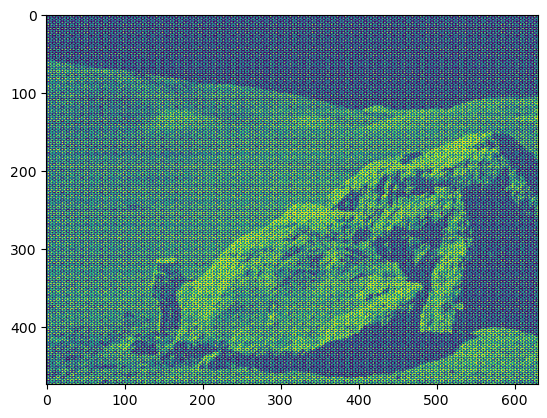

In [280]:
# Load the image using pylab.imread() and inspect it
image = plt.imread('moonlanding.png')
plt.imshow(image) #For grayscale images the output is a 2D array with shape (height, width) with values being the normalized intensity of each pixel in [0.0, 1.0]

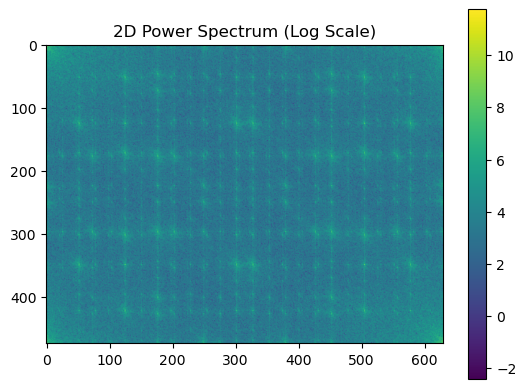

In [281]:
fft_image = fft2(image) ## 2-D FFT: it outputs the 2-D spatial frequency spectrum of the image 
power = np.abs(fft_image) # the module is the amplitude of each frequency 

plt.imshow(np.log(power))  # use log scale to make the graph readable
plt.title("2D Power Spectrum (Log Scale)")
plt.colorbar()

/var/folders/5q/jycjzrd11k1gq_4l_z12pgc00000gn/T/ipykernel_1041/2212188536.py:7: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(filt_power))


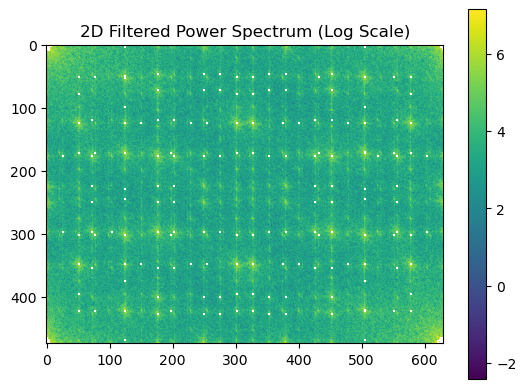

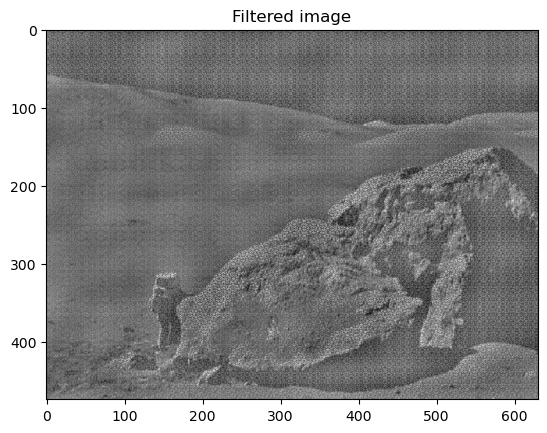

In [282]:
#Remove the high frequency noise by setting all values above a certain value to zero
threshold = 0.01
fft_image[power> (threshold * np.max(power))] = 0 # frequencies above 1% of maximum are removed
filt_power = np.abs(fft_image)

# plot of new power spectrum
plt.imshow(np.log(filt_power))
plt.title('2D Filtered Power Spectrum (Log Scale)')
plt.colorbar()
plt.show()

#Inverse fourier transform
filt_image = ifft2(fft_image).real   

#Plot of filtered image
plt.imshow(filt_image, cmap = 'gray')
plt.title('Filtered image')
plt.show()